In [1]:
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.patches import Circle
import xclimate as xclim

In [ ]:
variables = [
    "EFLX_LH_TOT_month_1",
    "TLAI_month_1",
]

time_slice = slice("1995-01", "2014-12")
year_start = time_slice.start[:4]
year_end = time_slice.stop[:4]
grid = xclim.load_fhist_ppe_grid()

snow_pct_threshold = 80    # maximum allowable percent of snow cover on all months of the average year
nonglc_pct_threshold = 80  # maximum allowable percent of glaciated land for a NON-glaciated gridcell

fsno = xclim.load_fhist("FSNO_month_1", keep_var_only=True)["FSNO"].sel(time=time_slice).reindex_like(grid, method="nearest", tolerance=1e-3)
fsno_clim_min = fsno.groupby("time.month").mean().min(dim="month")

# Create masks
snow_mask = fsno_clim_min <= (snow_pct_threshold / 100)
nonglc_mask = grid.PCT_GLC <= nonglc_pct_threshold
full_mask = snow_mask & nonglc_mask

fhist = {}
for v in variables:
    print(f"  {v}")
    name = "_".join(v.split("_")[:-2])
    fhist[v] = xclim.load_fhist(v, keep_var_only=True)[name].sel(time=time_slice).reindex_like(grid, method="nearest", tolerance=1e-3)
    fhist[v] = fhist[v].where(full_mask)
    fhist[v].attrs["masks"] = f"gridcell percent glaciated land <= {nonglc_pct_threshold}\ngridcell percent snow cover on all months of average year <= {snow_pct_threshold}"

fhist["EFLX_LH_TOT_year_1"] = fhist["EFLX_LH_TOT_month_1"].groupby("time.year").map(lambda x: x.weighted(x.time.dt.days_in_month).mean("time"))

  EFLX_LH_TOT_month_1


In [3]:
nb = 15
mask_type = "mask_glc80_snow80"
qbin_variables = [
    "AI_clim_1",

    "TLAI_month_1",
    "TLAI_year_1",
    "TLAI_clim_1",

    "GROWSN_TLAI_year_1",
    "GROWSN_TLAI_clim_1",

    "TOTANNPRECT_year_1",
    # "TOTANNPRECT_clim_1",

    "TSA_year_1",
    # "TSA_clim_1",
]
rootdir = Path("/glade/work/bbuchovecky/et_controls/proc/qbin")

qbin = {}
for v in qbin_variables:
    qbin[v] = xr.open_mfdataset(
        list((rootdir / mask_type / v).glob(f"qbin{nb}.1995-2014.TIMEagg.{v}.*.nc")),
        combine="nested",
        concat_dim="member",
    ).sortby("member").reindex_like(grid, method="nearest", tolerance=1e-3)

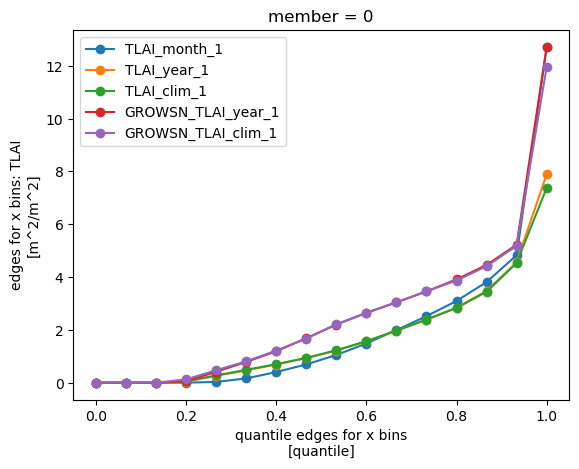

In [5]:
qbin["TLAI_month_1"].x_edge.isel(member=0).plot(marker="o", alpha=1, label="TLAI_month_1")
qbin["TLAI_year_1"].x_edge.isel(member=0).plot(marker="o", alpha=1, label="TLAI_year_1")
qbin["TLAI_clim_1"].x_edge.isel(member=0).plot(marker="o", alpha=1, label="TLAI_clim_1")
qbin["GROWSN_TLAI_year_1"].x_edge.isel(member=0).plot(marker="o", alpha=1, label="GROWSN_TLAI_year_1")
qbin["GROWSN_TLAI_clim_1"].x_edge.isel(member=0).plot(marker="o", alpha=1, label="GROWSN_TLAI_clim_1")
plt.legend(loc="upper left")

In [10]:
z_var = "EFLX_LH_TOT_month_1"
x_var = "AI_clim_1"
y_var = "TLAI_month_1"
alpha = 0.05
n_min = 50

# Select data
z = fhist[z_var].sel(member=slice(1, None)).drop_vars(['ltype', 'landunit']) - fhist[z_var].sel(member=0).drop_vars(['ltype', 'landunit'])
x_bin = qbin[x_var].sel(member=slice(1, None)).x_bin
y_bin = qbin[y_var].sel(member=slice(1, None)).x_bin

# Store metadata (d = delta, a = absolute)
z_type = "d"
x_type = "a"
y_type = "a"

# Compute bin stats
bs, sg = xclim.binned.full_bin_stats(z, x_bin, y_bin, nb, nb, z_time_coord="time")

# Get the bins for the default member
x_bin0 = qbin[x_var].sel(member=0).x_bin
y_bin0 = qbin[y_var].sel(member=0).x_bin
z0 = fhist[z_var].sel(member=0).drop_vars(['ltype', 'landunit'])
bs0, sg0 = xclim.binned.full_bin_stats(
    z, x_bin, y_bin, nb, nb, z_time_coord="time", alpha=alpha, n_min=n_min
)

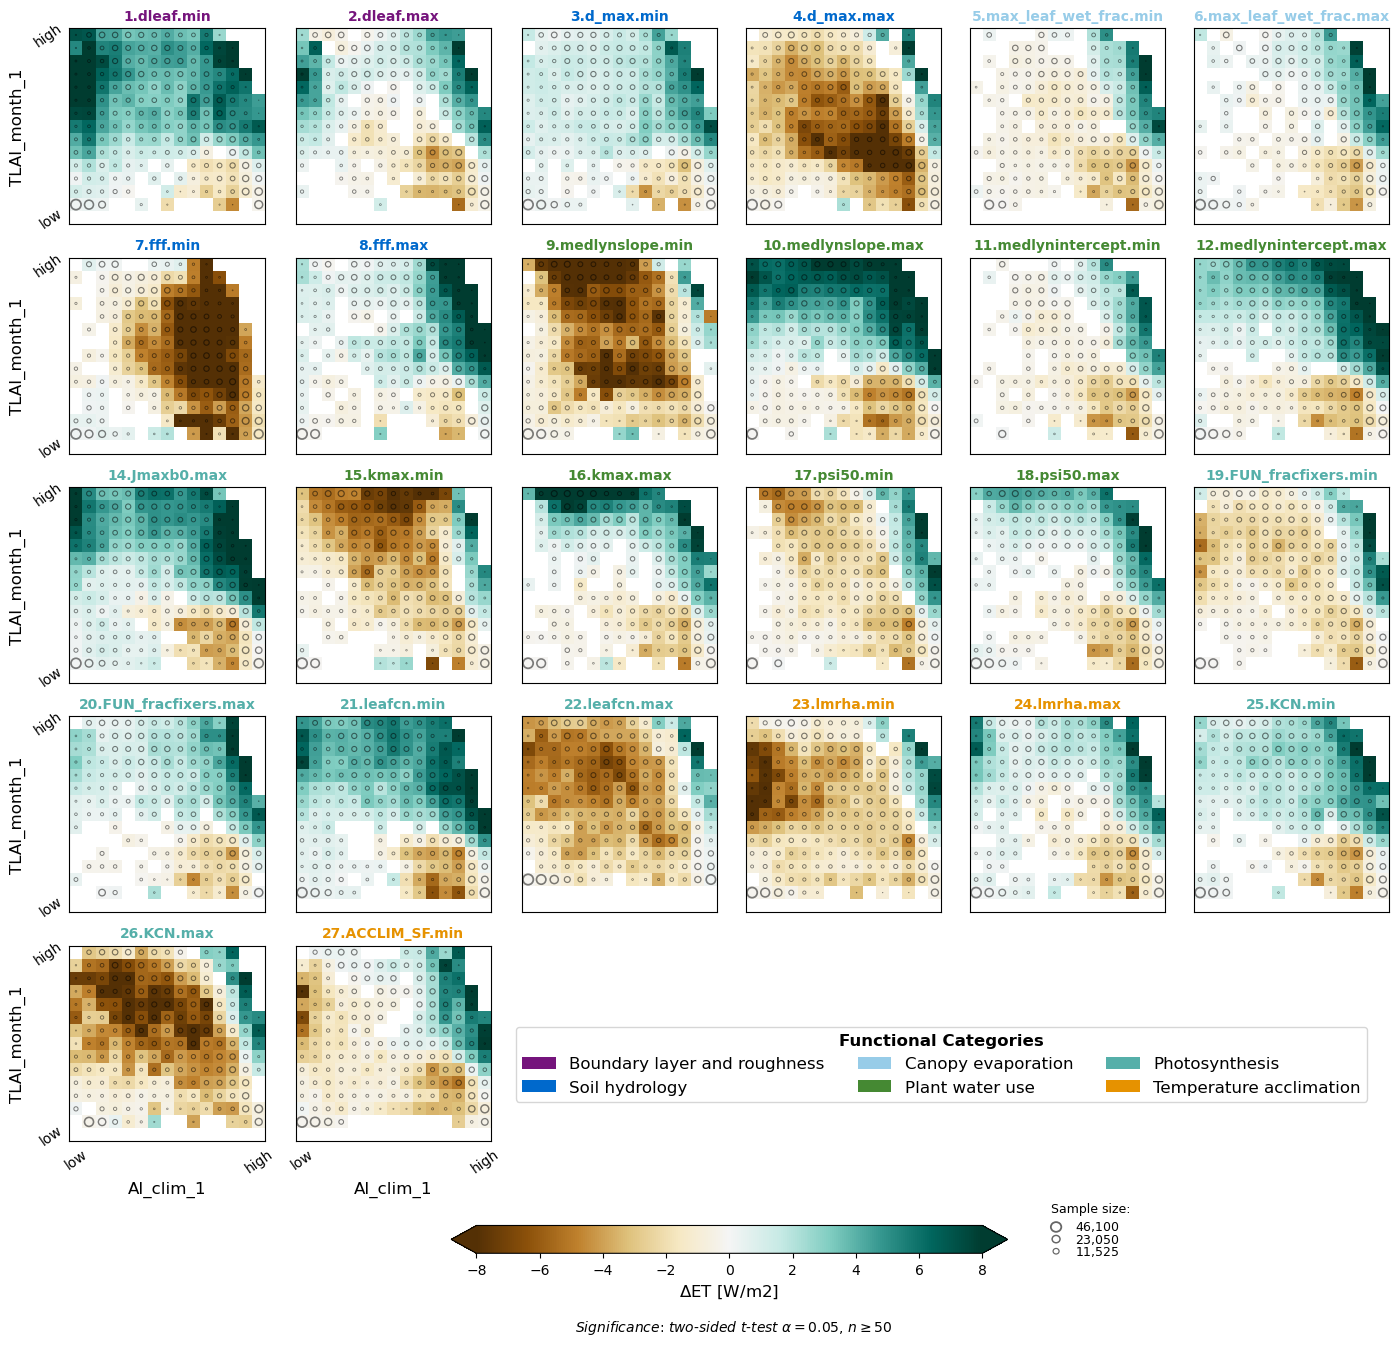

In [34]:
bm = bs.sel(stats_name="mean").where(sg).compute()
jh = bs.sel(stats_name="n").where(sg).compute()

vabs = 8
cmap = "BrBG"

scaling_power = 0.4  # use power scaling to draw out bins with lower sample size
ref_count = round(jh.max().values.item() / 1e2, 0) * 1e2
radius_scalar = 0.4
lw_scalar = 0.3
line_alpha = 0.5

ncols = 6
nrows = 5

fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows,
    sharex=True, sharey=True,
    figsize=(14, 13),
    subplot_kw=dict(box_aspect=1),
    constrained_layout=True,
    dpi=100,
)
ax = axs.flatten()

pcm = None
for i, m in enumerate(bm.member.values):
    pcm = ax[i].pcolormesh(bm.sel(member=m), shading="auto", cmap=cmap, vmin=-vabs, vmax=vabs)

    m_jh = jh.sel(member=m).T
    for ii in range(len(jh.ibx)):
        for jj in range(len(jh.iby)):
            count = m_jh.values[ii, jj]
            if count > 0:
                radius = radius_scalar * ((count / ref_count) ** scaling_power)
                lw = lw_scalar + ((count / ref_count) ** scaling_power)
                circle = Circle(
                    (ii + 0.5, jj + 0.5),
                    radius,
                    fill=False,
                    edgecolor="black",
                    linewidth=lw,
                    alpha=line_alpha,
                )
                ax[i].add_patch(circle)

    ax[i].set_title(
        xclim.ppe.get_member_name(m),
        color=xclim.ppe.get_member_cat_color(m),
        # color="k",
        fontsize=10,
        fontweight="bold",
        )
    ax[i].set_xlim(0, len(bm.ibx))
    ax[i].set_ylim(0, len(bm.iby))

    ax[i].set_yticks(np.arange(nb) + 0.5)
    ax[i].set_xticks(np.arange(nb) + 0.5)
    ax[i].tick_params(length=0)  # remove tick marks

    # Add 'low' and 'high' labels to the axes
    ticklabels = np.full((nb), "", dtype=object)
    ticklabels[0] = "low"
    ticklabels[-1] = "high"

    ax[i].set_yticklabels(ticklabels, rotation=35, ha="right", va="center")
    ax[i].set_xticklabels(ticklabels, rotation=35, ha="center", va="top")

    if i % ncols == 0:
        ax[i].set_ylabel(f"{y_var}", fontsize=12)
    if i // ncols == nrows - 1:
        ax[i].set_xlabel(f"{x_var}", fontsize=12)
    
    # Color the outer edge of the subplot corresponding to the parameter functional category
    # for spine in ax[i].spines.values():
    #     spine.set_color(xclim.ppe.get_member_cat_color(m))
    #     spine.set_linewidth(4)

# Add colorbar below all subplots
cbar = fig.colorbar(
    pcm,
    ax=axs,
    orientation="horizontal",
    extend="both",
    fraction=0.025,
    shrink=0.9,
    pad=0.025,
)
cbar.set_label("$\\Delta$ET [W/m2]", fontsize=12)

for i in range(len(bm.member), ncols * nrows):
    ax[i].remove()



# Create custom legend for member categories
# Get unique categories and their colors
categories = {}
for m in bm.member.values:
    cat = xclim.ppe.get_member_cat_name(m)
    color = xclim.ppe.get_member_cat_color(m)
    if cat not in categories:
        categories[cat] = color

# Create legend handles
legend_handles = [Patch(facecolor=color, label=cat) for cat, color in categories.items()]

# Add legend using figure coordinates
legend = fig.legend(
    handles=legend_handles,
    ncols=3,
    loc='lower right',
    bbox_to_anchor=(0.98, 0.15),
    bbox_transform=fig.transFigure,
    frameon=True,
    fontsize=12,
    title="Functional Categories",
    title_fontproperties={
        "weight": "bold",
        "size": 12,
    }
)


# Draw the figure to apply and fix layout
fig.canvas.draw()

# Get colorbar position
cbar_pos = cbar.ax.get_position()

# Add text below legend for alpha and n_min parameters
fig.text(
    (cbar_pos.x0 + cbar_pos.x1) / 2,
    cbar_pos.y0 - 0.05,
    f"$Significance$: $two$-$sided$ $t$-$test$ $\\alpha = {alpha}$, $n \\geq {n_min}$",
    ha="center",
    va="top",
    fontsize=10,
    transform=fig.transFigure,
)

# Create three reference circles of different sizes
scale_counts = [ref_count * 0.25, ref_count * 0.5, ref_count]

# Position for the scale circles
scale_x = cbar_pos.x1 + 0.05
scale_y_base = (cbar_pos.y0 + cbar_pos.y1) / 2

# Calculate spacing
max_radius_data = radius_scalar * ((scale_counts[-1] / ref_count) ** scaling_power)
point_data = np.array([[0, 0], [max_radius_data, 0]])
point_display = ax[0].transData.transform(point_data)
point_figure = fig.transFigure.inverted().transform(point_display)
max_radius_fig = np.linalg.norm(point_figure[1] - point_figure[0])

spacing = max_radius_fig * 2.5

for idx, scale_count in enumerate(scale_counts):
    # Calculate radius with same scaling
    data_radius = radius_scalar * ((scale_count / ref_count) ** scaling_power)
    scale_lw = lw_scalar + ((scale_count / ref_count) ** scaling_power)
    
    # Convert to figure coordinates
    point_data = np.array([[0, 0], [data_radius, 0]])
    point_display = ax[0].transData.transform(point_data)
    point_figure = fig.transFigure.inverted().transform(point_display)
    scale_radius = np.linalg.norm(point_figure[1] - point_figure[0])
    
    # Position circles vertically with spacing
    scale_y = scale_y_base + (idx - 1) * spacing
    
    scale_circle = Circle(
        (scale_x, scale_y),
        scale_radius,
        fill=False,
        edgecolor="black",
        linewidth=scale_lw,
        alpha=0.6,
        clip_on=False,
        transform=fig.transFigure,
    )
    fig.add_artist(scale_circle)
    
    fig.text(
        scale_x + max_radius_fig + 0.01,
        scale_y,
        f"{int(scale_count):,d}",
        ha="left",
        va="center",
        fontsize=9,
        transform=fig.transFigure,
    )

# Add label above reference circles
fig.text(
    scale_x - max_radius_fig,
    scale_y_base + idx  * spacing + 0.005,
    "Sample size:",
    ha="left",
    va="center",
    fontsize=9,
    transform=fig.transFigure,
)

fig.savefig(
    f"fig/qbin{nb}.{year_start}-{year_end}.TIMEagg.alpha{str(alpha).replace(".", "")}.nmin{n_min}.{x_type}x{x_var}.{y_type}y{y_var}.{z_type}z{z_var}.png",
    dpi=400, bbox_inches="tight")

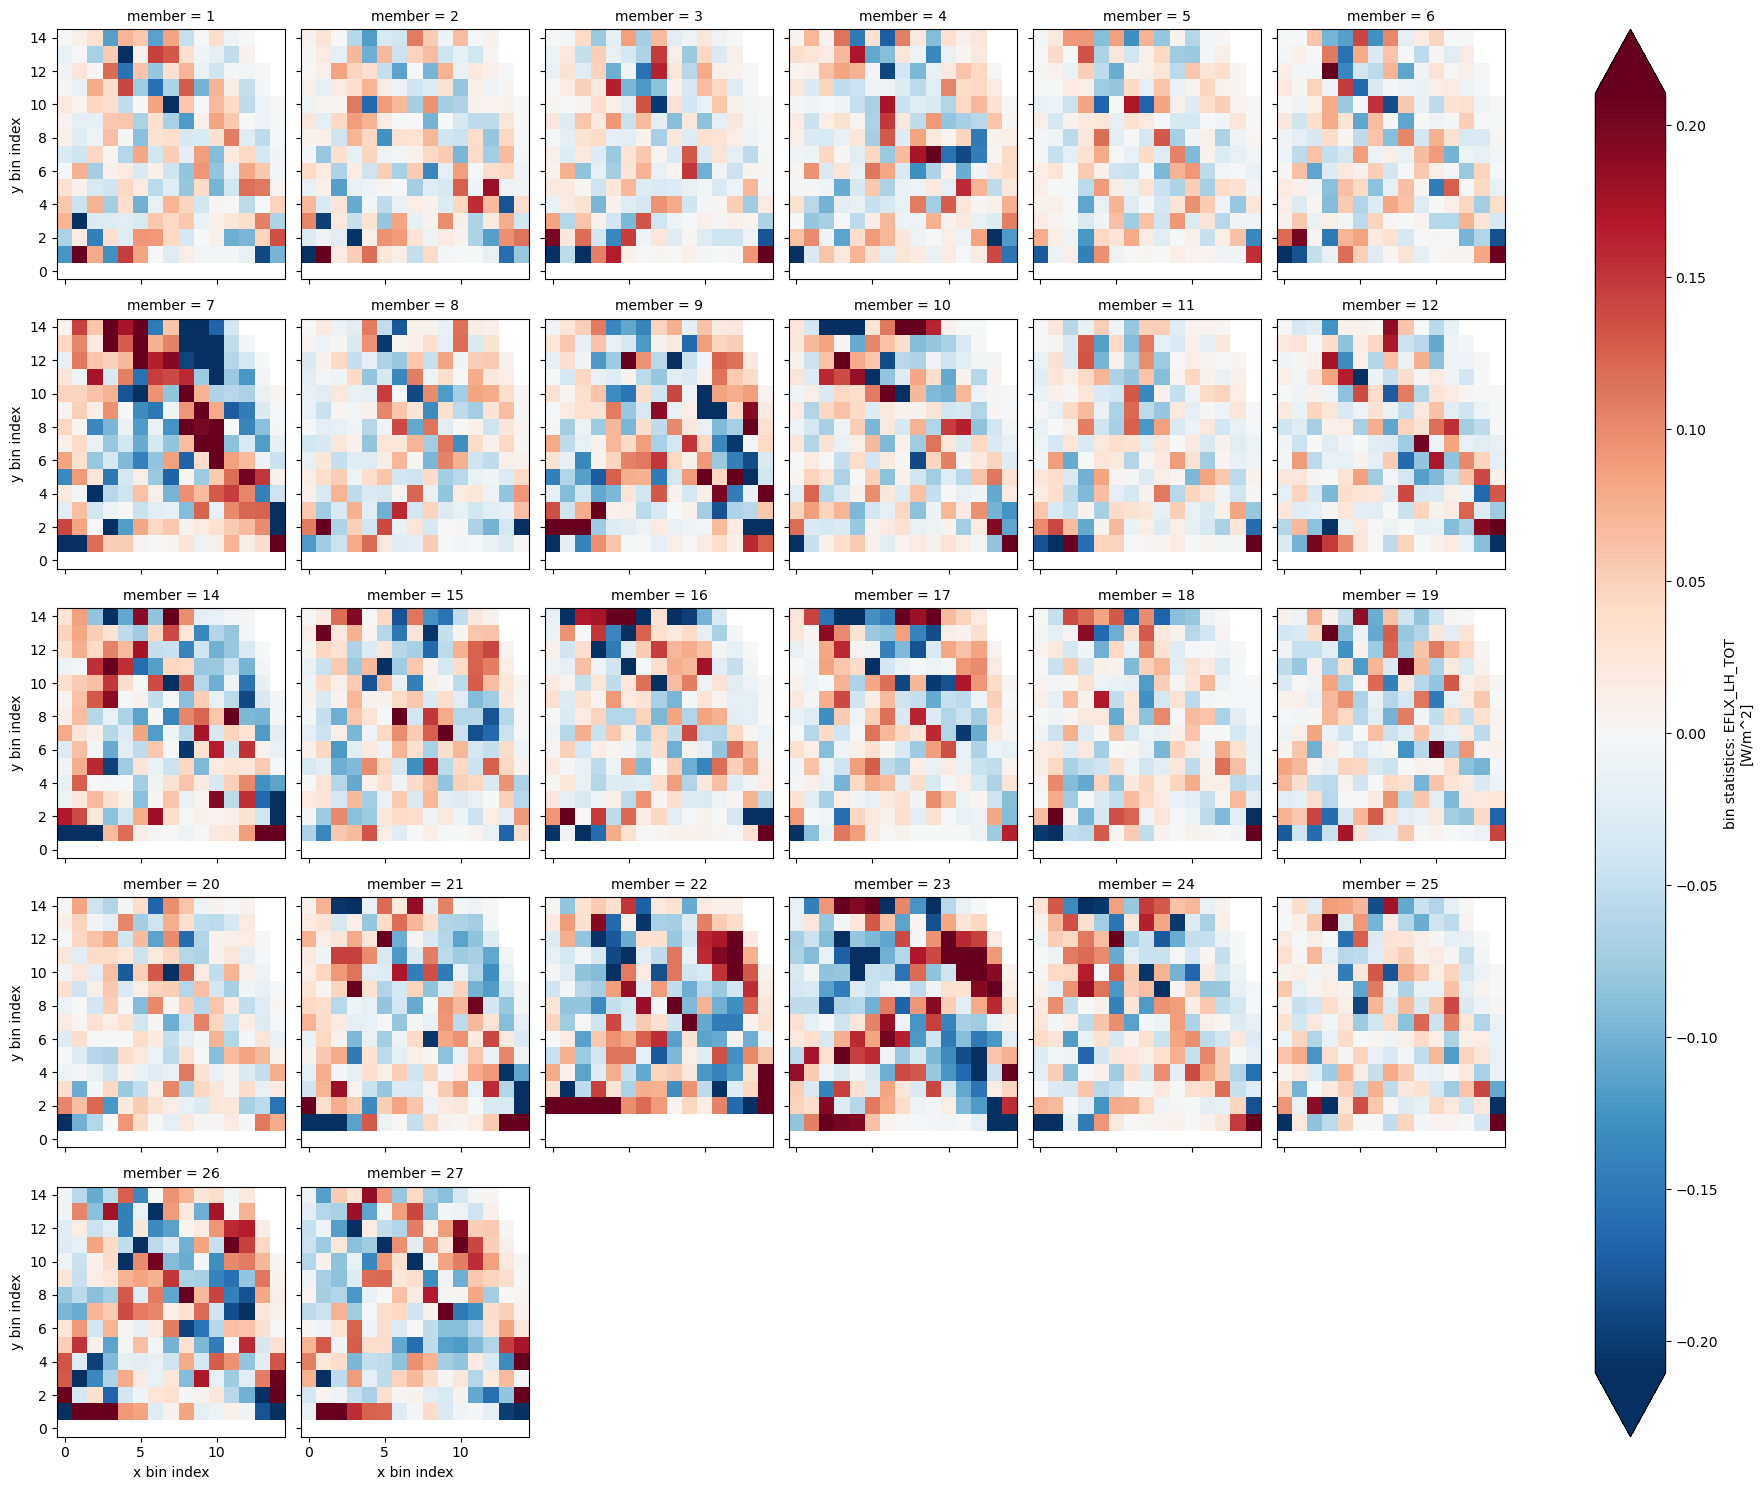

In [ ]:
jh = bs.sel(stats_name="n").compute()
jh_density = jh / jh.sum(dim=["ibx", "iby"])

jh0 = bs0.sel(stats_name="n").compute()
jh0_density = jh0 / jh0.sum(dim=["ibx", "iby"])

jh_diff = jh_density.sel(member=slice(1, None)) - jh0_density

fg = (jh_diff * 100).plot.pcolormesh(col="member", col_wrap=6, robust=True, cbar_kwargs={"label": "change in density"})